<a href="https://colab.research.google.com/github/chenboju/AI/blob/main/Fine_tuning_a_model_with_the_Trainer_Wandb_Chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning a model with the Trainer Wandb Chinese

## 安裝套件

In [1]:
!pip install datasets evaluate transformers[sentencepiece] --quiet
!pip install accelerate -U --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

# 從 Hugging Face Datasets 庫中載入一個名為 "sepidmnorozy/Chinese_sentiment" 的數據集
raw_datasets = load_dataset("sepidmnorozy/Chinese_sentiment")

# 選擇一個中文 BERT 模型的 checkpoint，這裡使用了 "google-bert/bert-base-chinese"
checkpoint = "google-bert/bert-base-chinese"

# 使用 AutoTokenizer 從選定的 checkpoint 中加載 tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 定義一個函數，用於對單個數據樣本進行標記化
def tokenize_function(example):
    # 對文本進行標記化，並設置截斷（truncation）為 True
    return tokenizer(example["text"], truncation=True)

# 使用 map 函數對數據集中的每個樣本進行標記化，並指定 batched=True 以進行批處理
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# 使用 DataCollatorWithPadding 來對標記化後的文本進行填充
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Generating train split:   0%|          | 0/12348 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2591 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4896 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Map:   0%|          | 0/12348 [00:00<?, ? examples/s]

Map:   0%|          | 0/2591 [00:00<?, ? examples/s]

Map:   0%|          | 0/4896 [00:00<?, ? examples/s]

### 定義`Trainer`的參數
我們定義我們之前的第一步`Trainer`是定義一個類別，其中包含將用於訓練和評估的`TrainingArguments`所有超參數。為求簡單，這邊`Trainer`提供的參數是儲存訓練模型的目錄以及訓練的輪數。對於其餘所有內容，保留預設值，這對於基本的微調應該非常有效。

In [4]:
from transformers import TrainingArguments

# 使用 TrainingArguments 類來設置訓練參數
# 將訓練過程中的所有信息報告給 W&B (Weights & Biases)
training_args = TrainingArguments(
    "test-trainer",  # 設置訓練過程中產生的所有文件和檢查點的保存路徑前綴
    num_train_epochs=3,  # 設置訓練的 epoch 數
    report_to="wandb"  # 報告訓練過程中的所有信息到 W&B
)


使用`AutoModelForSequenceClassification`有兩個標籤的類別

In [5]:
from transformers import AutoModelForSequenceClassification

# 使用 AutoModelForSequenceClassification 類從指定的 checkpoint 中加載模型
# 這個模型將用於序列分類任務，例如文本分類
# 在這裡，我們指定了分類的標籤數量為 2，這表示進行二元分類任務
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 說明
在實例化這個預訓練模型後會收到一個警告。這是因為BERT沒有在對句子對進行分類的任務上進行預訓練，因此預訓練模型的頭部被丟棄了(bert-base-uncase)，並且加入了一個適合序列分類的新頭部。表示有些權重未被使用（對應於被丟棄的預訓練頭部的那些）以及一些其他權重是隨機初始化的（新頭部）

### 定義`Trainer`
有了模型，就可以傳入建構的所有對象來定義一個訓練器模型、`training_args`、訓練和驗證資料集、`data_collator`和分詞器

In [6]:
from transformers import Trainer

# 創建一個 Trainer 實例，用於訓練模型
# 這個 Trainer 實例將使用指定的模型、訓練參數、訓練數據集、驗證數據集、數據收集器和 tokenizer 來進行訓練
trainer = Trainer(
    model,  # 指定要訓練的模型
    training_args,  # 指定訓練參數，例如訓練的 epoch 數等
    train_dataset=tokenized_datasets["train"],  # 指定訓練數據集
    eval_dataset=tokenized_datasets["validation"],  # 指定驗證數據集
    data_collator=data_collator,  # 指定數據收集器，用於對訓練數據進行填充等操作
    tokenizer=tokenizer,  # 指定 tokenizer，用於對文本進行標記化
)


### 說明
這樣傳遞分詞器時，訓練器使用的預設`data_collator`將是之前定義的`DataCollatorWithPadding`，因此可以跳過`data_collator=data_collator`這一行

### 開始訓練
呼叫`Trainer`中的`train()`方法

In [7]:
trainer.train()

wandb: Currently logged in as: qwe1120365 (chadqwe1120365). Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.462700
1000,0.409400
1500,0.375200
2000,0.336500
2500,0.299600
3000,0.316200
3500,0.251300
4000,0.233900
4500,0.195500


TrainOutput(global_step=4632, training_loss=0.31724648772126035, metrics={'train_runtime': 1394.9205, 'train_samples_per_second': 26.556, 'train_steps_per_second': 3.321, 'total_flos': 3856159738466400.0, 'train_loss': 0.31724648772126035, 'epoch': 3.0})

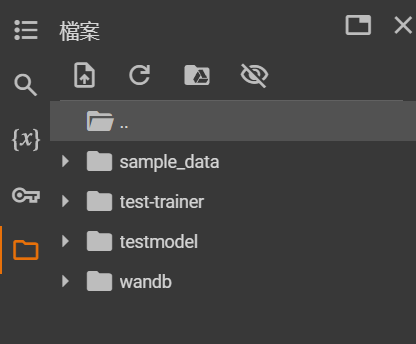

In [8]:
# 使用 Trainer 實例的 save_model 方法來保存訓練好的模型
# 指定保存的路徑為 "./testmodel"
trainer.save_model("./testmodel")


In [9]:
from transformers import pipeline

# 使用 pipeline 函數創建一個情感分析的 pipeline
# 這個 pipeline 將使用指定的模型進行情感分析
classifier = pipeline("sentiment-analysis", model="./testmodel")



In [13]:
classifier(
    [
        "真的很棒",
        "只會來這一次了",
        "我今天不開心",
        "今天天氣非常晴朗，我心情愉悅。",
        "看到他們快樂的笑容，我也感到非常開心。",
        "剛收到了一個好消息，讓我整個人都充滿了能量。",
        "經過了一天的辛勞工作，我感到有些疲憊，但也很滿足。",
        "這件事情讓我非常驚訝，我完全沒有想到會發生這樣的事情。"
    ]
)
#LABEL_1=正面
#LABEL_0=負面

[{'label': 'LABEL_1', 'score': 0.9989023208618164},
 {'label': 'LABEL_1', 'score': 0.9606990814208984},
 {'label': 'LABEL_0', 'score': 0.9969251751899719},
 {'label': 'LABEL_1', 'score': 0.9906361699104309},
 {'label': 'LABEL_1', 'score': 0.9940133690834045},
 {'label': 'LABEL_1', 'score': 0.9672703742980957},
 {'label': 'LABEL_1', 'score': 0.9987357258796692},
 {'label': 'LABEL_0', 'score': 0.9936121106147766}]

In [11]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}